# Proyecto de aprendizaje activo. Sergio Pérez Navarro

El objetivo de esta tarea es entrenar un clasificador SVM utilizando el menor número de muestras
posible, empezando por solo una muestra por clase, e ir añadiendo muestras en tandas de 1 a 4
muestras (a elegir) hasta llegar a un máximo de 100. Todos los métodos se repetiran 10 veces con el fin de acotar los resultados. Estos resultados serán representados en gráficas mostrando el intervalo de confianza que se ha considerado oportuno.

Por lo general los resultados son estables y suelen tener un comportamiento similar. No obstante el aspecto aleatorio de método random da en ciertas ocasiones resultados excepcionalmente buenos que desvirtuan los resultados.
Los métodos de aprendizaje activo que se van a estudiar son Random, Margin Sampling, MCLU, SSC, nEQB. Estos métodos serán empleados en distintos datasets (Wine y Glass).

Como el objetivo del proyecto es estudiar las diferencias de los métodos de aprendizaje y no ha perfeccionar el uso de las SVM, se ha evitado el empleo de crossvalidation con el fin de obtener diferencias mas abultadas en los resultados. Pues aun sin emplear esta técnica se obtienen resultados muy buenos con unos aciertos altisimos.

Comenzamos cargando las librerias que vamos a usar durante todo el proyecto

In [61]:
import numpy as np #Version:1.11.3
import matplotlib.pyplot as plt #Version:2.0.0
from sklearn.svm import SVC #Version:18.1
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.preprocessing import StandardScaler #Normalizar datos para el SVM
from al_base import ao
from scipy.stats import entropy #Version:18.1
import pandas as pd #Version:19.2
from sklearn.utils import resample
import seaborn as sns #Version:0.7.1
%matplotlib inline

In [62]:
def calc_entropy(vec): #Función empleada para el metodo nEQB
    vec = pd.Series(vec)
    dist = []
    clases = vec.unique()
    for clas in clases:
        dist.append(len(vec[vec == clas])/len(vec))
    
    return entropy(dist)

## Explicación de los métodos

### Random

Este método se basa en el puro azar para seleccionar que datos son consultados al oraculo. Es en principio el peor método y el más inconsistente. Si es cierto que en ocasiones por puro azar puede dar incluso mejores resultados que otros métodos más "inteligentes".

### Margin Sample (MS)

Consiste en observar cual es el dato que más incertidumbre tiene de ser clasificado correctamente. Esto se realiza empleando la distancia que tiene dicho dato con la frontera (hiperplano) de decisión de la SVM. Cuanto más cerca de la frontera más incertidumbre.

### Multiclass level uncertainty (MCLU)

Consiste en consultar las clases que más probabilidad tienen y obtener la diferencia entre estas probabilidades. Un valor pequeño nos dice que hay una clasificación poco clara y dudosa. Estos casos son los consultados con el oraculo.

### Significance space construction (SSC)

En este método se emplea un segundo clasificador el cual nos dice cuales son los proximos datos para consultar con el oraculo. Estos datos son los vectores soporte obtenidos del segundo modelo.

### Normalized entropy query-by-bagging (nEQB)

Por último, este método se basa en la entropía. Se emplea un comité de clasificadores cuyos resultados son comparados entre si empleando la entropía. Los casos son mayor entropía (y por lo tanto mayor variedad/discrepancia) son consultados al oraculo. Los casos con menor entropía (Menor variedad/discrepancia) son buenos resultados.


## Dataset Wine

A continuación cargamos los datos de wine. Los datos son escalados empleando StandardScaler pues vamos a trabajar con SVM. Este paso es necesario para una mejoría en clasificación.

In [63]:
# Load data wine
dire = 'E:\Documentos\Dropbox\ML2\AL\\' #Rutas donde se encuentran los datos
#dire = '/home/sergio/Dropbox/ML2/AL/'
data = np.loadtxt(dire+'wine.csv', delimiter=",")
X, y = data[:,1:], data[:,0]
X = StandardScaler().fit_transform(X) #Escalamos los datos para trabajar con la SVM

# Dataset variables
test_size = 0.3
labeled_size = 3

# AL Variables
num_queries = 100
queried_points = 1
num_models = 5 #nEQB

## Cálculo

In [64]:
random_accs = np.array([])
margin_accs = np.array([])
mclu_accs = np.array([])
ssc_accs = np.array([])
neqb_accs = np.array([])
time = np.array([])


for num_it in range(10):

    # Setup random and active objects
    random = ao()
    xtest, ytest = random.setup(X, y, labeled_size=labeled_size, test_size=test_size, random_state = num_it + 15 )
    margin = random.copy()
    mclu = random.copy()
    ssc = random.copy()
    neqb = random.copy()
    
    
    # Define classifiers
    random.classifier = SVC(gamma = random.gamma, C = 100)
    margin.classifier = SVC(gamma = margin.gamma, C = 100)
    #margin.classifier = OneVsRestClassifier(SVC(gamma = margin.gamma, C = 100))
    mclu.classifier = SVC(gamma = mclu.gamma, C = 100)
    ssc.classifier = SVC(gamma = ssc.gamma, C = 100)
    neqb.classifier = SVC(gamma = neqb.gamma, C = 100)
    
    
    for i in np.arange(0,num_queries):
        if len(margin.xunlab) < queried_points:
            break
        time = np.append(time, i)
        #1 Random
        random.classifier.fit(random.xlab, random.ylab)
        random.acc.append(random.classifier.score(xtest, ytest))
        idx = np.random.randint(len(random.xunlab), size = queried_points)
        random.updateLabels(idx)
    
        #2 MARGIN SAMPLING
        margin.classifier.fit(margin.xlab, margin.ylab)
        margin.acc.append(margin.classifier.score(xtest, ytest))
        yp = margin.classifier.decision_function(margin.xunlab)
        yp = np.abs(yp)
        yp.sort(axis = 1)
        fyp = yp[:,1] - yp[:,0]
        fyp = yp[:,0]
        idx = fyp.argsort()[:queried_points]
        margin.updateLabels(idx)
        
        #3 MCLU
        mclu.classifier.fit(mclu.xlab, mclu.ylab)
        mclu.acc.append( mclu.classifier.score(xtest, ytest))
        
        yp = np.abs(mclu.classifier.decision_function(mclu.xunlab))
        yp.sort(axis=1)
        fyp = yp[:,-1] - yp[:,-2]
        idx = fyp.argsort()[:queried_points]
        mclu.updateLabels(idx)
        
        
        #4 SSC
        
        ssc.classifier.fit(ssc.xlab, ssc.ylab)
        ssc.acc.append(ssc.classifier.score(xtest, ytest))
            
                #SEGUNDO MODELO
        
        sndModel = SVC(gamma = ssc.gamma, C = 100)
        Y = np.zeros(ssc.ylab.shape)
        Y[ssc.classifier.support_] = 1.0
        if max(Y) == min(Y): #En caso de tener una clase, quitamos uno de los datos.
            Y[-1] = 0
        sndModel.fit(ssc.xlab, Y)
        yp = sndModel.predict(ssc.xunlab)
        idx = np.nonzero(yp)[0][0:queried_points]
        ssc.updateLabels(idx)
    
        #5 nEQB
        

        neqb.classifier.fit(neqb.xlab, neqb.ylab)
        neqb.acc.append(neqb.classifier.score(xtest, ytest))
        
        
        model = SVC(gamma = neqb.gamma, C = 100)
        yp = np.zeros((len(neqb.xunlab), num_models))
        
        for m in np.arange(num_models):
            xx, yy = resample(neqb.xlab, neqb.ylab, n_samples = int(np.fix(0.7 * len(neqb.ylab))))
            while max(yy) == min(yy):
                xx, yy = resample(neqb.xlab, neqb.ylab,n_samples = int(np.fix(0.7 * len(neqb.ylab))))
            model.fit(xx, yy)
            yp[:,m] = model.predict(neqb.xunlab)
            
            
        ype = []
        ype.append(calc_entropy(yp[0,:]))
        ype.append(calc_entropy(yp[1,:]))
        ype.append(calc_entropy(yp[2,:]))
        ype.append(calc_entropy(yp[3,:]))
        ype.append(calc_entropy(yp[4,:]))
            
        idx = np.argsort(entropy(ype))[:queried_points]
        neqb.updateLabels(idx)
        
    random_accs = np.append(random_accs, random.acc)
    margin_accs = np.append(margin_accs, margin.acc)
    mclu_accs = np.append(mclu_accs,mclu.acc)
    ssc_accs = np.append(ssc_accs, ssc.acc)
    neqb_accs = np.append(neqb_accs, neqb.acc)
    
nombres = ["Random"] * len(random_accs) + ["Margin"] * len(margin_accs) + ["MCLU"] * len(mclu_accs) + ["SSC"] * len(ssc_accs) + ["nEQB"] * len(neqb_accs)
time = np.repeat(time,5)
accs = np.hstack((random_accs, margin_accs, mclu_accs, ssc_accs, neqb_accs))
units = [1,2,3,4,5] * 1000
df = pd.DataFrame({"Time":time, "Accuracy":accs, "Nombre":nombres, "Units":units})
    
random_accs = random_accs.reshape(10,100)
margin_accs = margin_accs.reshape(10,100)
mclu_accs = mclu_accs.reshape(10,100)
ssc_accs = ssc_accs.reshape(10,100)
neqb_accs = neqb_accs.reshape(10,100)

print("Resultado final") 
print('random ACC', random.acc[1], 'Margin ACC', margin.acc[-1], 'MCLU ACC', mclu.acc[-1], 
      'SSC ACC', ssc.acc[-1], 'nEQB ACC', neqb.acc[-1])

C:\Users\Sergio\Anaconda3\lib\site-packages\sklearn\svm\base.py:552: ChangedBehaviorWarning: The decision_function_shape default value will change from 'ovo' to 'ovr' in 0.19. This will change the shape of the decision function returned by SVC.
  "SVC.", ChangedBehaviorWarning)
C:\Users\Sergio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2491: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


Resultado final
random ACC 0.888888888889 Margin ACC 0.981481481481 MCLU ACC 0.981481481481 SSC ACC 0.981481481481 nEQB ACC 0.981481481481


Representación de uno de los casos individual.

(<matplotlib.legend.Legend at 0x1e433d3a58>, None)

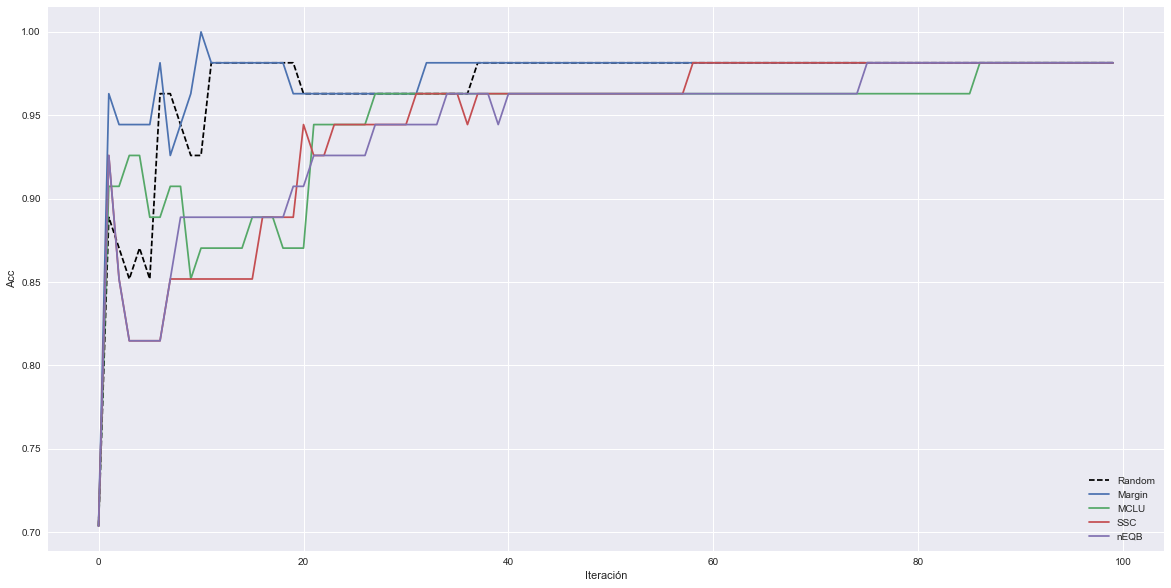

In [65]:
plt.figure(figsize=(20,10))
plt.plot(random.acc, 'k--', label="Random")
plt.plot(margin.acc, label="Margin")
plt.plot(mclu.acc, label="MCLU")
plt.plot(ssc.acc, label="SSC")
plt.plot(neqb.acc, label="nEQB")
plt.xlabel("Iteración")
plt.ylabel("Acc")
plt.legend(loc=4), plt.grid(1)

A continuación representamos las desviaciones para cada método en comparación con el método Random

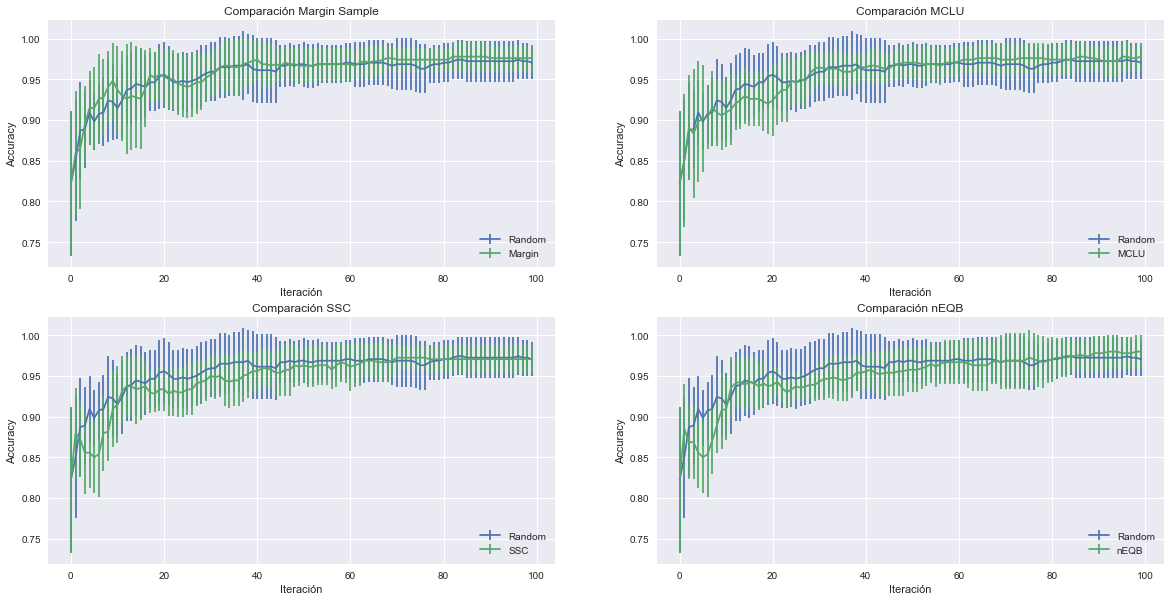

In [66]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(margin.acc)),np.mean(margin_accs, axis=0), yerr=np.std(margin_accs, axis=0), label="Margin")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación Margin Sample")
plt.subplot(222)
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(mclu.acc)),np.mean(mclu_accs, axis=0), yerr=np.std(mclu_accs, axis=0), label="MCLU")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación MCLU")
plt.subplot(223)
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(ssc.acc)),np.mean(ssc_accs, axis=0), yerr=np.std(ssc_accs, axis=0), label="SSC")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación SSC")
plt.subplot(224)
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(neqb.acc)),np.mean(neqb_accs, axis=0), yerr=np.std(neqb_accs, axis=0), label="nEQB")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación nEQB")

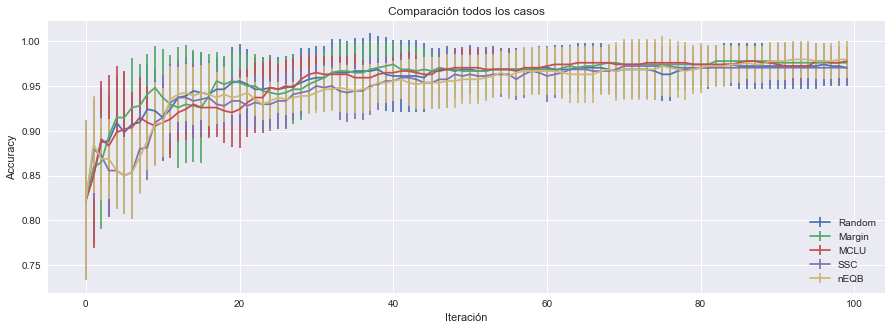

In [67]:
plt.figure(figsize=(15,5))
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(margin.acc)),np.mean(margin_accs, axis=0), yerr=np.std(margin_accs, axis=0), label="Margin")
plt.errorbar(np.arange(len(mclu.acc)),np.mean(mclu_accs, axis=0), yerr=np.std(mclu_accs, axis=0), label="MCLU")
plt.errorbar(np.arange(len(ssc.acc)),np.mean(ssc_accs, axis=0), yerr=np.std(ssc_accs, axis=0), label="SSC")
plt.errorbar(np.arange(len(neqb.acc)),np.mean(neqb_accs, axis=0), yerr=np.std(neqb_accs, axis=0), label="nEQB")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación todos los casos")

Realizamos una comparación de intervalos de confianza

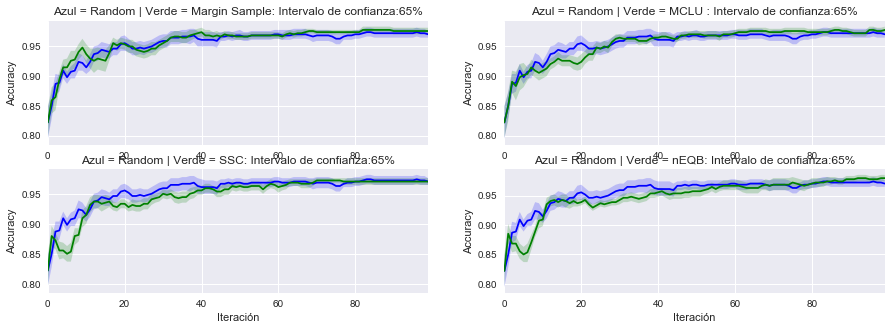

In [68]:
plt.figure(figsize=(15,5))
plt.subplot(221)
sns.tsplot(random_accs, color="blue", ci=65)
sns.tsplot(margin_accs, color="green", ci=65)
plt.title("Azul = Random | Verde = Margin Sample: Intervalo de confianza:65%")
plt.ylabel("Accuracy")

plt.subplot(222)
sns.tsplot(random_accs, color="blue", ci=65)
sns.tsplot(mclu_accs, color="green", ci=65)
plt.title("Azul = Random | Verde = MCLU : Intervalo de confianza:65%")
plt.ylabel("Accuracy")

plt.subplot(223)
sns.tsplot(random_accs, color="blue", ci=65)
sns.tsplot(ssc_accs, color="green", ci=65)
plt.title("Azul = Random | Verde = SSC: Intervalo de confianza:65%")
plt.xlabel("Iteración")
plt.ylabel("Accuracy")

plt.subplot(224)
sns.tsplot(random_accs, color="blue", ci=65)
sns.tsplot(neqb_accs, color="green", ci=65)
plt.title("Azul = Random | Verde = nEQB: Intervalo de confianza:65%")
plt.xlabel("Iteración")
plt.ylabel("Accuracy")

Como podemos comprobar, practicamente todos los métodos ganan al caso aleatorio. Para cuando se alcanzan unas 80 iteraciones (tomando queried_points en cada una de ellas) practicamente todos los modelos mantienen el mismo resultado. Lo importante es comprobar que efectivamente los métodos no aleatorios dan un mejor aprendizaje con menos iteraciones. A continuación hacemos un ajuste de los resultados en accuracy de los modelos. Lineales y de segundo orden.

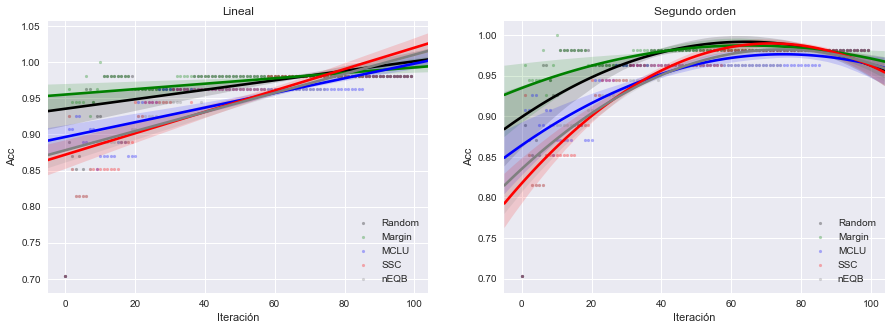

In [69]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.regplot(x=np.arange(len(random.acc)),y=np.array(random.acc), order=1, label="Random", color="black", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(margin.acc)),y=np.array(margin.acc), order=1, label="Margin",color="green", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(mclu.acc)),y=np.array(mclu.acc), order=1, label="MCLU", color="blue", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(ssc.acc)),y=np.array(ssc.acc), order=1, label="SSC", color="red", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(neqb.acc)),y=np.array(neqb.acc), order=1, label="nEQB", color="grey", scatter_kws={'s':10, 'alpha':0.3})
plt.xlabel("Iteración")
plt.ylabel("Acc")
plt.title("Lineal")
plt.legend(loc=4)

plt.subplot(122)
sns.regplot(x=np.arange(len(random.acc)),y=np.array(random.acc), order=2, label="Random", color="black", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(margin.acc)),y=np.array(margin.acc), order=2, label="Margin",color="green", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(mclu.acc)),y=np.array(mclu.acc), order=2, label="MCLU", color="blue", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(ssc.acc)),y=np.array(ssc.acc), order=2, label="SSC", color="red", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(neqb.acc)),y=np.array(neqb.acc), order=2, label="nEQB", color="grey", scatter_kws={'s':10, 'alpha':0.3})
plt.xlabel("Iteración")
plt.ylabel("Acc")
plt.title("Segundo orden")
plt.legend(loc=4)

# Dataset Glass

Vamos a repetir el mismo procedimiento con el dataset Glass. Las descripciones de los siguientes apartados son identicas al caso anterior.

In [70]:
dire = 'E:\Documentos\Dropbox\ML2\AL\\'
#dire = '/home/sergio/Dropbox/ML2/AL/'
data = np.loadtxt(dire+'glass.data', delimiter=",")
X, y = data[:,1:-1], data[:,-1]
X = StandardScaler().fit_transform(X)

# Dataset variables
test_size = 0.3
labeled_size = 6

# AL Variables
num_queries = 100
queried_points = 1
num_models = 5 #nEQB

random_accs = np.array([])
margin_accs = np.array([])
mclu_accs = np.array([])
ssc_accs = np.array([])
neqb_accs = np.array([])
time = np.array([])

## Cálculo

In [71]:
random_accs = np.array([])
margin_accs = np.array([])
mclu_accs = np.array([])
ssc_accs = np.array([])
neqb_accs = np.array([])
time = np.array([])


for num_it in range(10):

    # Setup random and active objects
    random = ao()
    xtest, ytest = random.setup(X, y, labeled_size=labeled_size, test_size=test_size, random_state = num_it+ 10 )
    margin = random.copy()
    mclu = random.copy()
    ssc = random.copy()
    neqb = random.copy()
    
    
    # Define classifiers
    random.classifier = SVC(gamma = random.gamma, C = 100)
    margin.classifier = SVC(gamma = margin.gamma, C = 100)
    #margin.classifier = OneVsRestClassifier(SVC(gamma = margin.gamma, C = 100))
    mclu.classifier = SVC(gamma = mclu.gamma, C = 100)
    ssc.classifier = SVC(gamma = ssc.gamma, C = 100)
    neqb.classifier = SVC(gamma = neqb.gamma, C = 100)
    
    
    for i in np.arange(0,num_queries):
        if len(margin.xunlab) < queried_points:
            break
        time = np.append(time, i)
        #1 Random
        random.classifier.fit(random.xlab, random.ylab)
        random.acc.append(random.classifier.score(xtest, ytest))
        idx = np.random.randint(len(random.xunlab), size = queried_points)
        random.updateLabels(idx)
    
        #2 MARGIN SAMPLING
        margin.classifier.fit(margin.xlab, margin.ylab)
        margin.acc.append(margin.classifier.score(xtest, ytest))
        yp = margin.classifier.decision_function(margin.xunlab)
        yp = np.abs(yp)
        yp.sort(axis = 1)
        fyp = yp[:,1] - yp[:,0]
        fyp = yp[:,0]
        idx = fyp.argsort()[:queried_points]
        margin.updateLabels(idx)
        
        #3 MCLU
        mclu.classifier.fit(mclu.xlab, mclu.ylab)
        mclu.acc.append( mclu.classifier.score(xtest, ytest))
        
        yp = np.abs(mclu.classifier.decision_function(mclu.xunlab))
        yp.sort(axis=1)
        fyp = yp[:,-1] - yp[:,-2]
        idx = fyp.argsort()[:queried_points]
        mclu.updateLabels(idx)
        
        
        #4 SSC
        
        ssc.classifier.fit(ssc.xlab, ssc.ylab)
        ssc.acc.append(ssc.classifier.score(xtest, ytest))
            
                #SEGUNDO MODELO
        
        sndModel = SVC(gamma = ssc.gamma, C = 100)
        Y = np.zeros(ssc.ylab.shape)
        Y[ssc.classifier.support_] = 1.0
        if max(Y) == min(Y): #En caso de tener una clase, quitamos uno de los datos.
            Y[-1] = 0
        sndModel.fit(ssc.xlab, Y)
        yp = sndModel.predict(ssc.xunlab)
        idx = np.nonzero(yp)[0][0:queried_points]
        ssc.updateLabels(idx)
    
        #5 nEQB
        

        neqb.classifier.fit(neqb.xlab, neqb.ylab)
        neqb.acc.append(neqb.classifier.score(xtest, ytest))
        
        
        model = SVC(gamma = neqb.gamma, C = 100)
        yp = np.zeros((len(neqb.xunlab), num_models))
        
        for m in np.arange(num_models):
            xx, yy = resample(neqb.xlab, neqb.ylab, n_samples = int(np.fix(0.7 * len(neqb.ylab))))
            while max(yy) == min(yy):
                xx, yy = resample(neqb.xlab, neqb.ylab,n_samples = int(np.fix(0.7 * len(neqb.ylab))))
            model.fit(xx, yy)
            yp[:,m] = model.predict(neqb.xunlab)
            
            
        ype = []
        ype.append(calc_entropy(yp[0,:]))
        ype.append(calc_entropy(yp[1,:]))
        ype.append(calc_entropy(yp[2,:]))
        ype.append(calc_entropy(yp[3,:]))
        ype.append(calc_entropy(yp[4,:]))
            
        idx = np.argsort(entropy(ype))[:queried_points]
        neqb.updateLabels(idx)
        
    random_accs = np.append(random_accs, random.acc)
    margin_accs = np.append(margin_accs, margin.acc)
    mclu_accs = np.append(mclu_accs,mclu.acc)
    ssc_accs = np.append(ssc_accs, ssc.acc)
    neqb_accs = np.append(neqb_accs, neqb.acc)
    
nombres = ["Random"] * len(random_accs) + ["Margin"] * len(margin_accs) + ["MCLU"] * len(mclu_accs) + ["SSC"] * len(ssc_accs) + ["nEQB"] * len(neqb_accs)
time = np.repeat(time,5)
accs = np.hstack((random_accs, margin_accs, mclu_accs, ssc_accs, neqb_accs))
units = [1,2,3,4,5] * 1000
df = pd.DataFrame({"Time":time, "Accuracy":accs, "Nombre":nombres, "Units":units})
    
random_accs = random_accs.reshape(10,100)
margin_accs = margin_accs.reshape(10,100)
mclu_accs = mclu_accs.reshape(10,100)
ssc_accs = ssc_accs.reshape(10,100)
neqb_accs = neqb_accs.reshape(10,100)

print("Resultado final") 
print('random ACC', random.acc[1], 'Margin ACC', margin.acc[-1], 'MCLU ACC', mclu.acc[-1], 
      'SSC ACC', ssc.acc[-1], 'nEQB ACC', neqb.acc[-1])

C:\Users\Sergio\Anaconda3\lib\site-packages\sklearn\svm\base.py:552: ChangedBehaviorWarning: The decision_function_shape default value will change from 'ovo' to 'ovr' in 0.19. This will change the shape of the decision function returned by SVC.
  "SVC.", ChangedBehaviorWarning)
C:\Users\Sergio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2491: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


Resultado final
random ACC 0.507692307692 Margin ACC 0.707692307692 MCLU ACC 0.723076923077 SSC ACC 0.692307692308 nEQB ACC 0.723076923077


(<matplotlib.legend.Legend at 0x1e441ee2e8>, None)

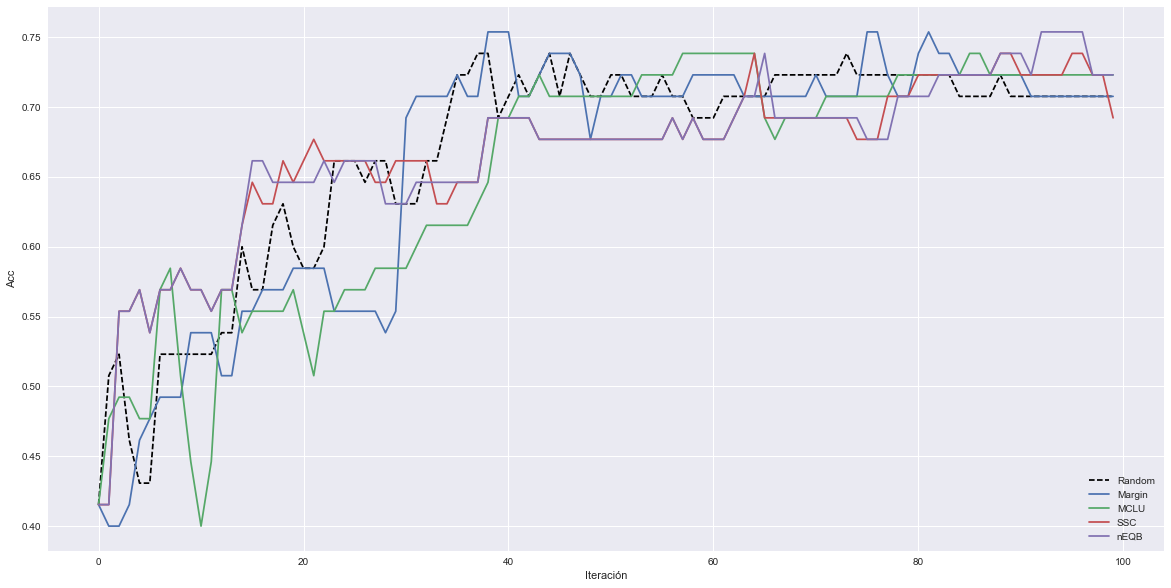

In [72]:
plt.figure(figsize=(20,10))
plt.plot(random.acc, 'k--', label="Random")
plt.plot(margin.acc, label="Margin")
plt.plot(mclu.acc, label="MCLU")
plt.plot(ssc.acc, label="SSC")
plt.plot(neqb.acc, label="nEQB")
plt.xlabel("Iteración")
plt.ylabel("Acc")
plt.legend(loc=4), plt.grid(1)

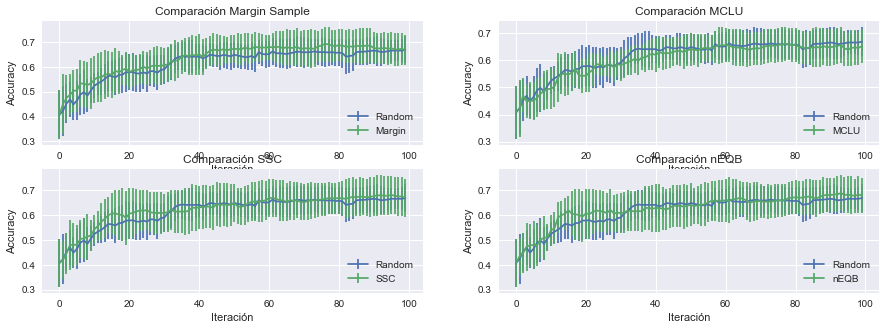

In [73]:
plt.figure(figsize=(15,5))
plt.subplot(221)
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(margin.acc)),np.mean(margin_accs, axis=0), yerr=np.std(margin_accs, axis=0), label="Margin")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación Margin Sample")

plt.subplot(222)
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(mclu.acc)),np.mean(mclu_accs, axis=0), yerr=np.std(mclu_accs, axis=0), label="MCLU")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación MCLU")

plt.subplot(223)
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(ssc.acc)),np.mean(ssc_accs, axis=0), yerr=np.std(ssc_accs, axis=0), label="SSC")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación SSC")

plt.subplot(224)
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(neqb.acc)),np.mean(neqb_accs, axis=0), yerr=np.std(neqb_accs, axis=0), label="nEQB")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación nEQB")



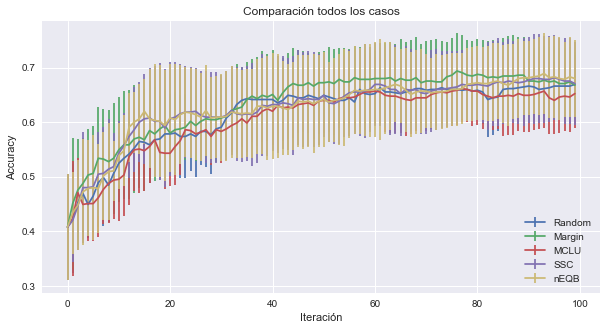

In [74]:
plt.figure(figsize=(10,5))
plt.errorbar(np.arange(len(random.acc)),np.mean(random_accs, axis=0), yerr=np.std(random_accs, axis=0), label="Random")
plt.errorbar(np.arange(len(margin.acc)),np.mean(margin_accs, axis=0), yerr=np.std(margin_accs, axis=0), label="Margin")
plt.errorbar(np.arange(len(mclu.acc)),np.mean(mclu_accs, axis=0), yerr=np.std(mclu_accs, axis=0), label="MCLU")
plt.errorbar(np.arange(len(ssc.acc)),np.mean(ssc_accs, axis=0), yerr=np.std(ssc_accs, axis=0), label="SSC")
plt.errorbar(np.arange(len(neqb.acc)),np.mean(neqb_accs, axis=0), yerr=np.std(neqb_accs, axis=0), label="nEQB")
plt.legend(loc=4), plt.grid(1)
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.title("Comparación todos los casos")

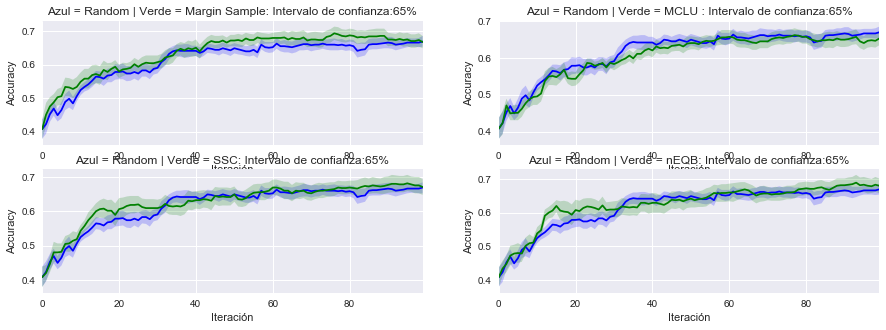

In [75]:
plt.figure(figsize=(15,5))
plt.subplot(221)
sns.tsplot(random_accs, color="blue", ci=65)
sns.tsplot(margin_accs, color="green", ci=65)
plt.title("Azul = Random | Verde = Margin Sample: Intervalo de confianza:65%")
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.subplot(222)
sns.tsplot(random_accs, color="blue", ci=65)
sns.tsplot(mclu_accs, color="green", ci=65)
plt.title("Azul = Random | Verde = MCLU : Intervalo de confianza:65%")
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.subplot(223)
sns.tsplot(random_accs, color="blue", ci=65)
sns.tsplot(ssc_accs, color="green", ci=65)
plt.title("Azul = Random | Verde = SSC: Intervalo de confianza:65%")
plt.xlabel("Iteración")
plt.ylabel("Accuracy")
plt.subplot(224)
sns.tsplot(random_accs, color="blue", ci=65)
sns.tsplot(neqb_accs, color="green", ci=65)
plt.title("Azul = Random | Verde = nEQB: Intervalo de confianza:65%")
plt.xlabel("Iteración")
plt.ylabel("Accuracy")

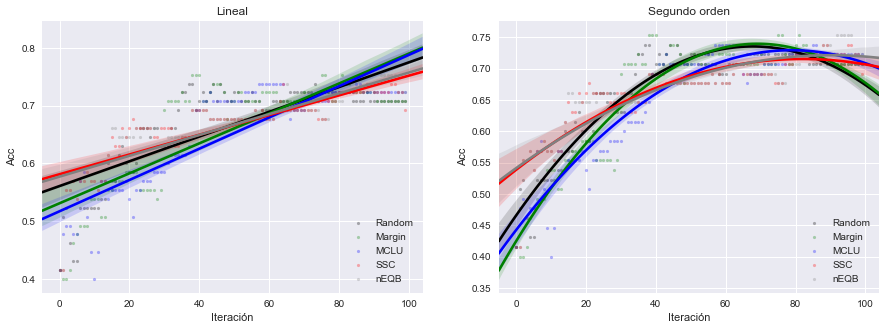

In [76]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.regplot(x=np.arange(len(random.acc)),y=np.array(random.acc), order=1, label="Random", color="black", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(margin.acc)),y=np.array(margin.acc), order=1, label="Margin",color="green", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(mclu.acc)),y=np.array(mclu.acc), order=1, label="MCLU", color="blue", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(ssc.acc)),y=np.array(ssc.acc), order=1, label="SSC", color="red", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(neqb.acc)),y=np.array(neqb.acc), order=1, label="nEQB", color="grey", scatter_kws={'s':10, 'alpha':0.3})
plt.xlabel("Iteración")
plt.ylabel("Acc")
plt.title("Lineal")
plt.legend(loc=4)

plt.subplot(122)
sns.regplot(x=np.arange(len(random.acc)),y=np.array(random.acc), order=2, label="Random", color="black", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(margin.acc)),y=np.array(margin.acc), order=2, label="Margin",color="green", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(mclu.acc)),y=np.array(mclu.acc), order=2, label="MCLU", color="blue", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(ssc.acc)),y=np.array(ssc.acc), order=2, label="SSC", color="red", scatter_kws={'s':10, 'alpha':0.3})
sns.regplot(x=np.arange(len(neqb.acc)),y=np.array(neqb.acc), order=2, label="nEQB", color="grey", scatter_kws={'s':10, 'alpha':0.3})
plt.xlabel("Iteración")
plt.ylabel("Acc")
plt.title("Segundo orden")
plt.legend(loc=4)

Una vez más comprobamos que aprendemos más rapidamente con los métodos no aleatorios pero conforme aprendemos muchos de los datos las diferencias son pequeñas. Podemos concluir que aunque los métodos más inteligentes dan mejores resultados, el método Random es francamente bueno en comparación para el tiempo empleado en su implementeación.